# E-Commerce Sales Analysis

## Table of Contents

1. [Introduction & Business Objectives](#1.-Introduction-&-Business-Objectives)
2. [Data Dictionary](#2.-Data-Dictionary)
3. [Configuration](#3.-Configuration)
4. [Data Loading](#4.-Data-Loading)
5. [Data Preparation & Transformation](#5.-Data-Preparation-&-Transformation)
6. [Business Metrics Analysis](#6.-Business-Metrics-Analysis)
   - [6.1 Revenue Analysis](#6.1-Revenue-Analysis)
   - [6.2 Product Analysis](#6.2-Product-Analysis)
   - [6.3 Geographic Analysis](#6.3-Geographic-Analysis)
   - [6.4 Customer Experience Analysis](#6.4-Customer-Experience-Analysis)
7. [Summary of Observations](#7.-Summary-of-Observations)

## 1. Introduction & Business Objectives

This notebook provides a comprehensive exploratory data analysis of e-commerce sales data. The analysis focuses on understanding business performance through key metrics and trends.

### Business Objectives

- Evaluate revenue performance and growth trends
- Identify top-performing product categories
- Analyze geographic distribution of sales
- Assess customer experience through delivery times and review scores
- Compare performance across different time periods

### Analysis Scope

This analysis can be configured to focus on any specific year and month combination, allowing for flexible period-over-period comparisons.

## 2. Data Dictionary

### Dataset Overview

The analysis uses the following datasets:

**Orders Dataset**
- `order_id`: Unique identifier for each order
- `customer_id`: Unique identifier for each customer
- `order_status`: Current status of the order (delivered, canceled, pending, processing, shipped, returned)
- `order_purchase_timestamp`: Date and time when the order was placed
- `order_approved_at`: Date and time when the order was approved
- `order_delivered_carrier_date`: Date when order was delivered to carrier
- `order_delivered_customer_date`: Date when order was delivered to customer
- `order_estimated_delivery_date`: Estimated delivery date

**Order Items Dataset**
- `order_id`: Reference to the order
- `order_item_id`: Sequential number identifying items within an order
- `product_id`: Unique identifier for the product
- `seller_id`: Unique identifier for the seller
- `price`: Item price in dollars
- `freight_value`: Shipping cost in dollars

**Products Dataset**
- `product_id`: Unique identifier for each product
- `product_category_name`: Product category
- `product_weight_g`: Product weight in grams
- `product_length_cm`, `product_height_cm`, `product_width_cm`: Product dimensions

**Customers Dataset**
- `customer_id`: Unique identifier for each customer
- `customer_unique_id`: Unique identifier across multiple orders
- `customer_zip_code_prefix`: First 5 digits of customer zip code
- `customer_city`: Customer city
- `customer_state`: Customer state abbreviation

**Reviews Dataset**
- `review_id`: Unique identifier for each review
- `order_id`: Reference to the order
- `review_score`: Rating from 1 to 5 given by the customer
- `review_creation_date`: Date when review was created

### Key Business Terms

- **Revenue**: Total sales amount from delivered orders only
- **Average Order Value (AOV)**: Average total price per order
- **Delivery Speed**: Number of days between order purchase and customer delivery
- **Review Score**: Customer satisfaction rating on a scale of 1-5

## 3. Configuration

Configure the analysis parameters below. The notebook will analyze data for the specified time period and compare it to the previous year.

In [2]:
# Analysis Configuration
ANALYSIS_YEAR = 2023        # Year to analyze
COMPARISON_YEAR = 2022      # Year to compare against
ANALYSIS_MONTH = None       # Set to specific month (1-12) or None for full year
DATA_DIR = 'ecommerce_data' # Directory containing CSV files

## 4. Data Loading

Load all required datasets and prepare them for analysis.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
import data_loader
import business_metrics

# Set display options
pd.set_option('display.float_format', '{:.2f}'.format)

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Load raw datasets
orders, order_items, products, customers, reviews = data_loader.load_raw_data(DATA_DIR)

print(f"Orders: {len(orders):,} records")
print(f"Order Items: {len(order_items):,} records")
print(f"Products: {len(products):,} records")
print(f"Customers: {len(customers):,} records")
print(f"Reviews: {len(reviews):,} records")

Orders: 10,000 records
Order Items: 16,047 records
Products: 6,000 records
Customers: 8,000 records
Reviews: 6,571 records


## 5. Data Preparation & Transformation

Prepare sales data for the analysis and comparison periods.

In [5]:
# Prepare sales data for analysis year
sales_current = data_loader.prepare_sales_data(
    data_dir=DATA_DIR,
    year=ANALYSIS_YEAR,
    month=ANALYSIS_MONTH,
    include_delivery_metrics=True
)

# Prepare sales data for comparison year
sales_previous = data_loader.prepare_sales_data(
    data_dir=DATA_DIR,
    year=COMPARISON_YEAR,
    month=ANALYSIS_MONTH,
    include_delivery_metrics=True
)

# Display period labels
if ANALYSIS_MONTH:
    period_label = f"{pd.to_datetime(f'{ANALYSIS_YEAR}-{ANALYSIS_MONTH}', format='%Y-%m').strftime('%B %Y')}"
    comparison_label = f"{pd.to_datetime(f'{COMPARISON_YEAR}-{ANALYSIS_MONTH}', format='%Y-%m').strftime('%B %Y')}"
else:
    period_label = str(ANALYSIS_YEAR)
    comparison_label = str(COMPARISON_YEAR)

print(f"Analysis Period: {period_label}")
print(f"Comparison Period: {comparison_label}")
print(f"\nDelivered orders in {period_label}: {len(sales_current):,}")
print(f"Delivered orders in {comparison_label}: {len(sales_previous):,}")

Analysis Period: 2023
Comparison Period: 2022

Delivered orders in 2023: 7,448
Delivered orders in 2022: 7,641


In [6]:
# Display sample of processed data
print("Sample of processed sales data:")
sales_current.head()

Sample of processed sales data:


,order_id,order_item_id,product_id,price,order_status,order_purchase_timestamp,order_delivered_customer_date,month,year,delivery_speed,delivery_time
2,ord_5fa044951857e02fd1347b47,1,prod_9b6f1793388ae983f852d189,111.91,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,4,2023,6,4-7 days
3,ord_5fa044951857e02fd1347b47,2,prod_c7b5997a4d0061a9f50e874c,878.42,delivered,2023-04-24 13:05:32.579655,2023-05-01 02:05:32.579655,4,2023,6,4-7 days
7,ord_43b53981d951f855231d09ec,1,prod_496e129d773e9587e8ddc065,749.83,delivered,2023-12-10 05:13:58.249202,2023-12-19 09:13:58.249202,12,2023,9,8+ days
8,ord_e60b1e267fd32d93c4d0745b,1,prod_139fc7c40b163ec81342741e,361.54,delivered,2023-04-11 05:42:57.214593,2023-04-22 20:42:57.214593,4,2023,11,8+ days
9,ord_e60b1e267fd32d93c4d0745b,2,prod_8668b3ebccd7183bae97138a,25.59,delivered,2023-04-11 05:42:57.214593,2023-04-22 20:42:57.214593,4,2023,11,8+ days


## 6. Business Metrics Analysis

### 6.1 Revenue Analysis

Analyze revenue performance including total revenue, growth rates, and trends.

In [7]:
# Generate comprehensive revenue summary
revenue_summary = business_metrics.generate_revenue_summary(sales_current, sales_previous)

# Display key metrics
print("=" * 60)
print(f"REVENUE PERFORMANCE: {period_label} vs {comparison_label}")
print("=" * 60)
print(f"\nTotal Revenue:")
print(f"  {period_label}: ${revenue_summary['current_revenue']:,.2f}")
print(f"  {comparison_label}: ${revenue_summary['previous_revenue']:,.2f}")
print(f"  Growth: {revenue_summary['revenue_growth']*100:+.2f}%")

print(f"\nAverage Order Value:")
print(f"  {period_label}: ${revenue_summary['current_aov']:,.2f}")
print(f"  {comparison_label}: ${revenue_summary['previous_aov']:,.2f}")
print(f"  Growth: {revenue_summary['aov_growth']*100:+.2f}%")

print(f"\nTotal Orders:")
print(f"  {period_label}: {revenue_summary['current_orders']:,}")
print(f"  {comparison_label}: {revenue_summary['previous_orders']:,}")
print(f"  Growth: {revenue_summary['order_growth']*100:+.2f}%")

if ANALYSIS_MONTH is None:
    print(f"\nAverage Monthly Growth Rate: {revenue_summary['avg_monthly_growth']*100:+.2f}%")
print("=" * 60)

REVENUE PERFORMANCE: 2023 vs 2022

Total Revenue:
  2023: $3,360,294.74
  2022: $3,445,076.96
  Growth: -2.46%

Average Order Value:
  2023: $724.98
  2022: $725.43
  Growth: -0.06%

Total Orders:
  2023: 4,635
  2022: 4,749
  Growth: -2.40%

Average Monthly Growth Rate: -0.39%


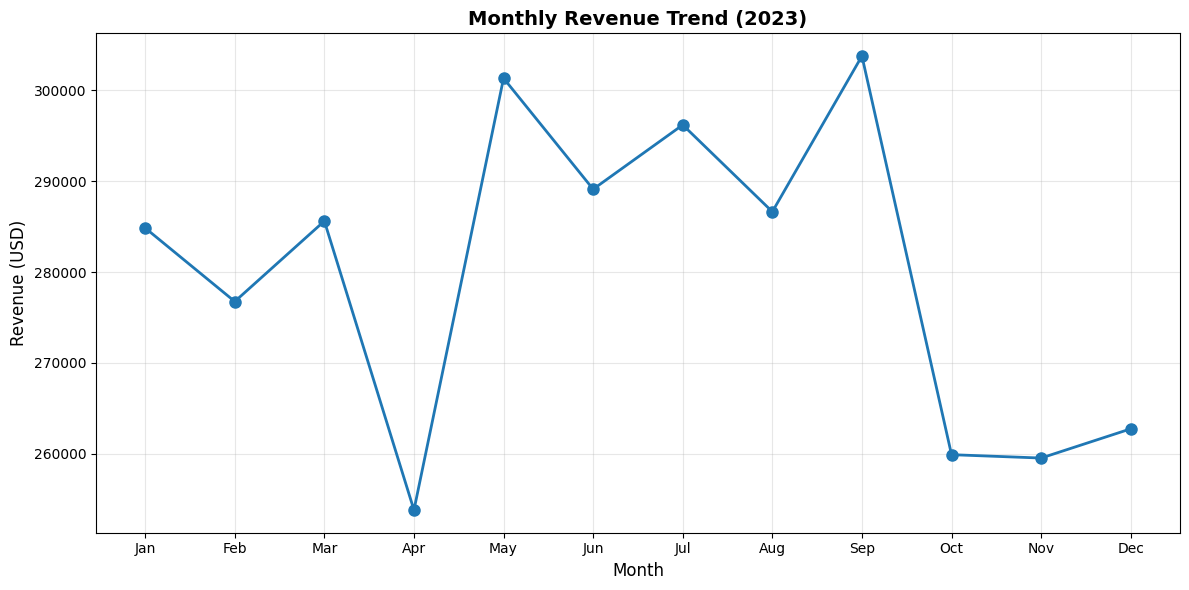

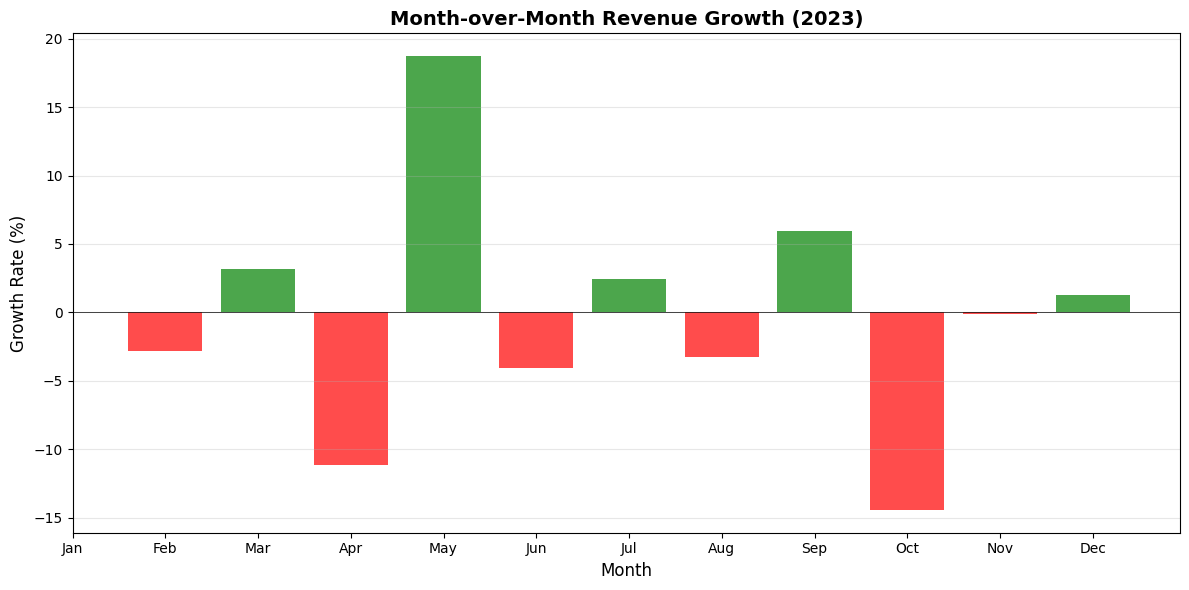

In [8]:
# Monthly revenue trend (only for full year analysis)
if ANALYSIS_MONTH is None:
    monthly_revenue = business_metrics.get_monthly_revenue(sales_current)
    
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_revenue['month'], monthly_revenue['price'], marker='o', linewidth=2, markersize=8)
    plt.title(f'Monthly Revenue Trend ({period_label})', fontsize=14, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Revenue (USD)', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Month-over-month growth
    monthly_growth = business_metrics.calculate_monthly_growth(sales_current)
    
    plt.figure(figsize=(12, 6))
    colors = ['green' if x >= 0 else 'red' for x in monthly_growth.values]
    plt.bar(monthly_growth.index, monthly_growth.values * 100, color=colors, alpha=0.7)
    plt.title(f'Month-over-Month Revenue Growth ({period_label})', fontsize=14, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Growth Rate (%)', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

### 6.2 Product Analysis

Analyze product category performance and identify top-performing categories.

In [9]:
# Calculate sales by product category
category_sales = business_metrics.get_product_category_sales(sales_current, products)

print(f"Top 10 Product Categories by Revenue ({period_label}):")
print("=" * 60)
for idx, row in category_sales.head(10).iterrows():
    print(f"{idx+1:2d}. {row['product_category_name']:30s} ${row['price']:>12,.2f}")
print("=" * 60)

Top 10 Product Categories by Revenue (2023):
 1. electronics                    $1,401,359.21
 2. home_garden                    $  862,653.27
 3. sports_outdoors                $  278,845.32
 4. automotive                     $  247,707.10
 5. clothing_shoes_jewelry         $  232,745.04
 6. toys_games                     $   70,163.64
 7. health_personal_care           $   65,370.27
 8. tools_home_improvement         $   54,280.33
 9. beauty_personal_care           $   49,213.30
10. books_media                    $   38,559.08


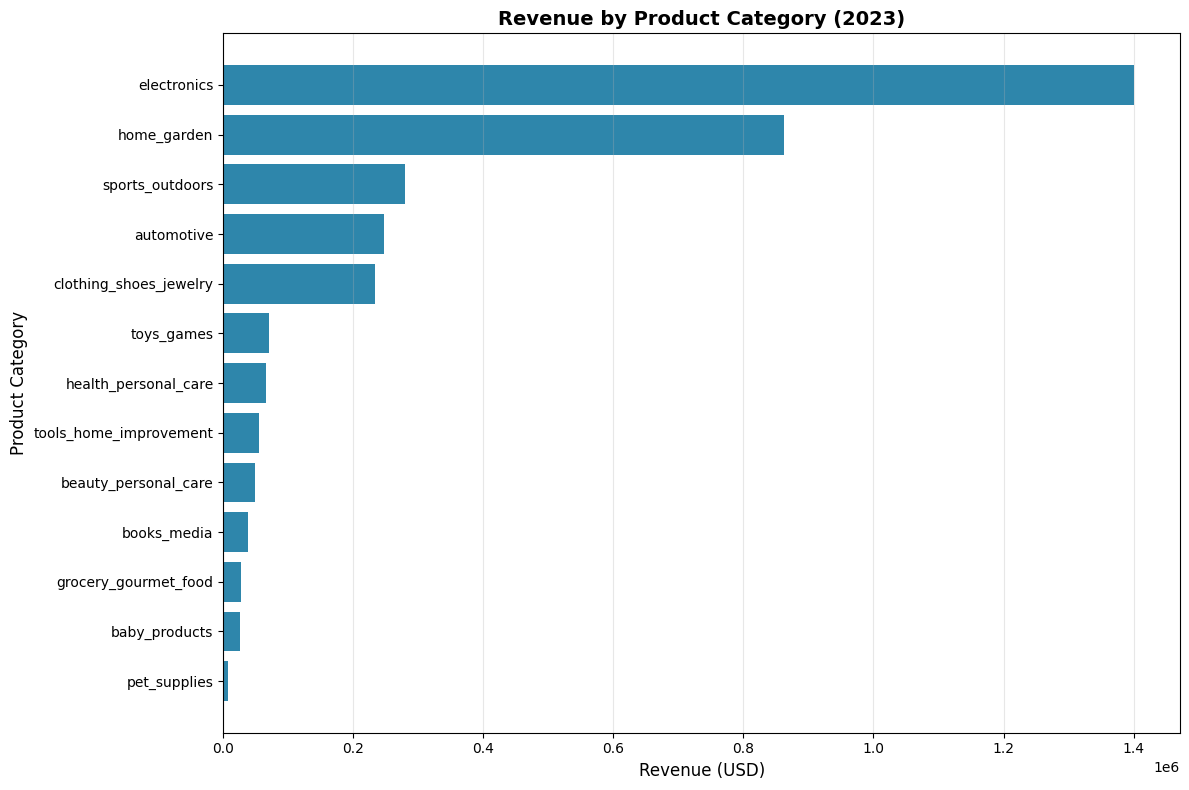

In [10]:
# Visualize top product categories
plt.figure(figsize=(12, 8))
top_categories = category_sales.head(13)
plt.barh(top_categories['product_category_name'], top_categories['price'], color='#2E86AB')
plt.title(f'Revenue by Product Category ({period_label})', fontsize=14, fontweight='bold')
plt.xlabel('Revenue (USD)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 6.3 Geographic Analysis

Analyze sales distribution across different states and identify key markets.

In [11]:
# Calculate sales by state
state_sales = business_metrics.get_sales_by_state(sales_current, orders, customers)

print(f"Top 10 States by Revenue ({period_label}):")
print("=" * 50)
for idx, row in state_sales.head(10).iterrows():
    print(f"{idx+1:2d}. {row['customer_state']:5s} ${row['price']:>12,.2f}")
print("=" * 50)

Top 10 States by Revenue (2023):
 1. CA    $  537,880.74
 2. TX    $  403,303.49
 3. FL    $  310,195.84
 4. NY    $  253,111.85
 5. IL    $  185,930.89
 6. PA    $  173,260.68
 7. OH    $  157,619.72
 8. GA    $  146,414.65
 9. MI    $  132,325.60
10. NC    $  128,314.74


In [12]:
# Visualize geographic distribution
fig = px.choropleth(
    state_sales,
    locations='customer_state',
    color='price',
    locationmode='USA-states',
    scope='usa',
    title=f'Revenue by State ({period_label})',
    color_continuous_scale='Blues',
    labels={'price': 'Revenue (USD)'}
)
fig.update_layout(
    title_font_size=16,
    title_font_family='Arial',
    title_font_color='black'
)
fig.show()

### 6.4 Customer Experience Analysis

Analyze customer satisfaction metrics including delivery times and review scores.

In [13]:
# Calculate customer experience metrics
avg_delivery_time = business_metrics.calculate_average_delivery_time(sales_current)
avg_review_score = business_metrics.calculate_average_review_score(sales_current, reviews)
review_distribution = business_metrics.get_review_score_distribution(sales_current, reviews)
review_by_delivery = business_metrics.get_review_by_delivery_time(sales_current, reviews)
order_status_dist = business_metrics.get_order_status_distribution(orders, ANALYSIS_YEAR)

print("=" * 60)
print(f"CUSTOMER EXPERIENCE METRICS: {period_label}")
print("=" * 60)
print(f"\nAverage Delivery Time: {avg_delivery_time:.1f} days")
print(f"Average Review Score: {avg_review_score:.2f} / 5.00")
print("\nOrder Status Distribution:")
for status, pct in order_status_dist.items():
    print(f"  {status:15s}: {pct*100:5.1f}%")
print("=" * 60)

CUSTOMER EXPERIENCE METRICS: 2023

Average Delivery Time: 8.0 days
Average Review Score: 4.10 / 5.00

Order Status Distribution:
  delivered      :  93.6%
  shipped        :   3.2%
  canceled       :   1.3%
  processing     :   1.2%
  pending        :   0.5%
  returned       :   0.2%


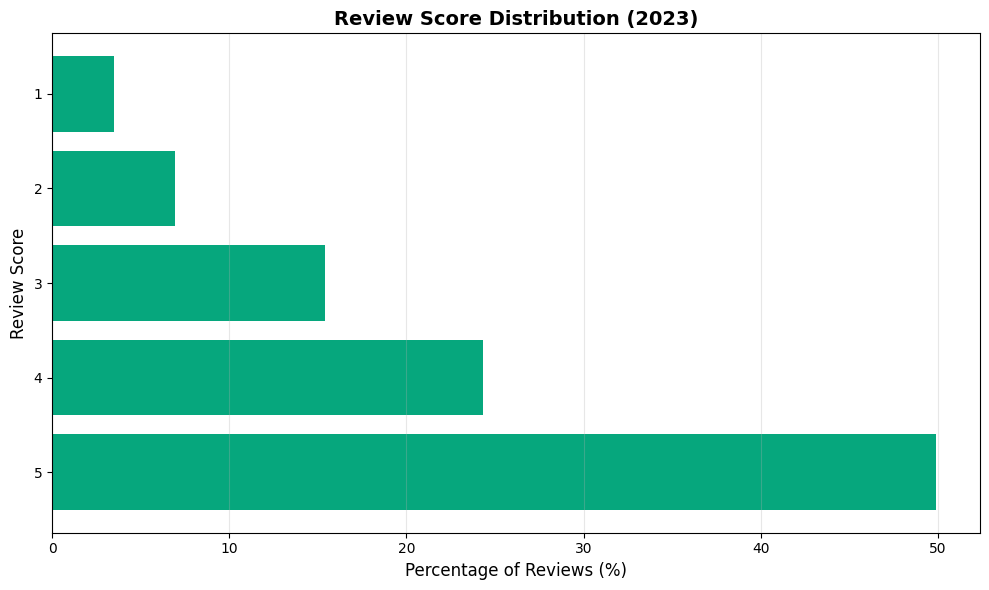

In [14]:
# Visualize review score distribution
plt.figure(figsize=(10, 6))
plt.barh(review_distribution.index, review_distribution.values * 100, color='#06A77D')
plt.title(f'Review Score Distribution ({period_label})', fontsize=14, fontweight='bold')
plt.xlabel('Percentage of Reviews (%)', fontsize=12)
plt.ylabel('Review Score', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

Average Review Score by Delivery Time Category (2023):
1-3 days  : 4.19 / 5.00
4-7 days  : 4.08 / 5.00
8+ days   : 4.11 / 5.00


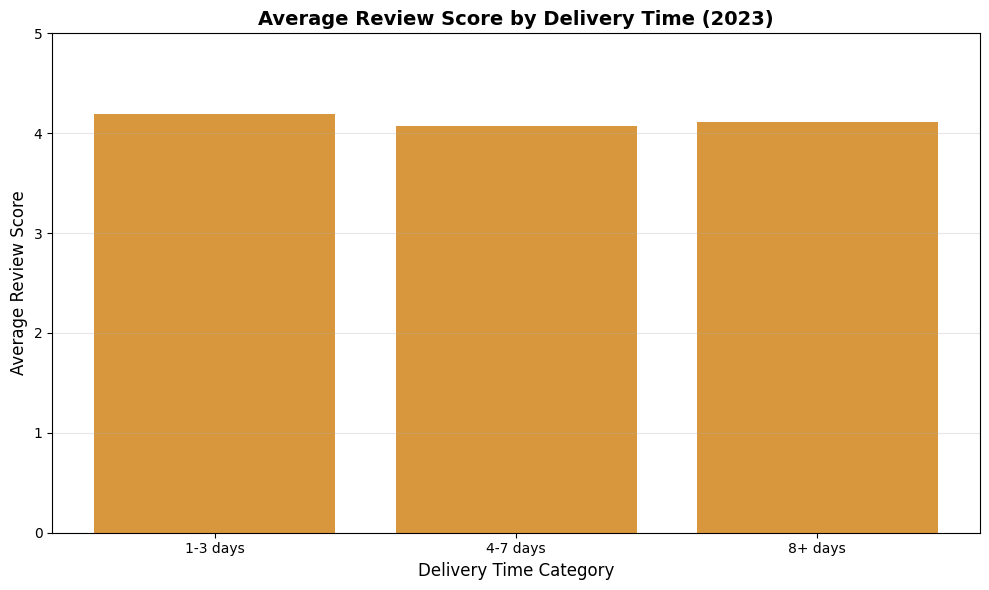

In [15]:
# Analyze relationship between delivery time and review scores
print(f"Average Review Score by Delivery Time Category ({period_label}):")
print("=" * 50)
for idx, row in review_by_delivery.iterrows():
    print(f"{row['delivery_time']:10s}: {row['review_score']:.2f} / 5.00")
print("=" * 50)

# Visualize
plt.figure(figsize=(10, 6))
delivery_order = ['1-3 days', '4-7 days', '8+ days']
review_by_delivery_sorted = review_by_delivery.set_index('delivery_time').loc[delivery_order].reset_index()
plt.bar(review_by_delivery_sorted['delivery_time'], review_by_delivery_sorted['review_score'], color='#D8973C')
plt.title(f'Average Review Score by Delivery Time ({period_label})', fontsize=14, fontweight='bold')
plt.xlabel('Delivery Time Category', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.ylim(0, 5)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. Summary of Observations

This section summarizes key findings from the analysis.

In [16]:
# Generate automated summary
print("=" * 70)
print(f"EXECUTIVE SUMMARY: {period_label} Performance")
print("=" * 70)

# Revenue insights
print("\n1. REVENUE PERFORMANCE")
print(f"   - Total revenue: ${revenue_summary['current_revenue']:,.2f}")
revenue_direction = "increased" if revenue_summary['revenue_growth'] > 0 else "decreased"
print(f"   - Revenue {revenue_direction} by {abs(revenue_summary['revenue_growth'])*100:.2f}% compared to {comparison_label}")
print(f"   - Average order value: ${revenue_summary['current_aov']:,.2f}")
print(f"   - Total orders: {revenue_summary['current_orders']:,}")

# Product insights
print("\n2. PRODUCT PERFORMANCE")
top_category = category_sales.iloc[0]
print(f"   - Top category: {top_category['product_category_name']}")
print(f"   - Top category revenue: ${top_category['price']:,.2f}")
top_3_revenue = category_sales.head(3)['price'].sum()
total_revenue = category_sales['price'].sum()
print(f"   - Top 3 categories represent {(top_3_revenue/total_revenue)*100:.1f}% of total revenue")

# Geographic insights
print("\n3. GEOGRAPHIC DISTRIBUTION")
top_state = state_sales.iloc[0]
print(f"   - Top state: {top_state['customer_state']}")
print(f"   - Top state revenue: ${top_state['price']:,.2f}")
top_5_states_revenue = state_sales.head(5)['price'].sum()
print(f"   - Top 5 states represent {(top_5_states_revenue/total_revenue)*100:.1f}% of total revenue")

# Customer experience insights
print("\n4. CUSTOMER EXPERIENCE")
print(f"   - Average delivery time: {avg_delivery_time:.1f} days")
print(f"   - Average review score: {avg_review_score:.2f} / 5.00")
print(f"   - Successful delivery rate: {order_status_dist.get('delivered', 0)*100:.1f}%")
high_score_pct = review_distribution.loc[review_distribution.index >= 4].sum()
print(f"   - Reviews with 4-5 stars: {high_score_pct*100:.1f}%")

# Delivery insights
best_delivery = review_by_delivery.loc[review_by_delivery['review_score'].idxmax()]
print(f"   - Best reviewed delivery category: {best_delivery['delivery_time']}")

print("\n" + "=" * 70)

EXECUTIVE SUMMARY: 2023 Performance

1. REVENUE PERFORMANCE
   - Total revenue: $3,360,294.74
   - Revenue decreased by 2.46% compared to 2022
   - Average order value: $724.98
   - Total orders: 4,635

2. PRODUCT PERFORMANCE
   - Top category: electronics
   - Top category revenue: $1,401,359.21
   - Top 3 categories represent 75.7% of total revenue

3. GEOGRAPHIC DISTRIBUTION
   - Top state: CA
   - Top state revenue: $537,880.74
   - Top 5 states represent 50.3% of total revenue

4. CUSTOMER EXPERIENCE
   - Average delivery time: 8.0 days
   - Average review score: 4.10 / 5.00
   - Successful delivery rate: 93.6%
   - Reviews with 4-5 stars: 74.2%
   - Best reviewed delivery category: 1-3 days

